In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.transform as sktr
import os
import time

# # name of the input file
# file_list = os.listdir('./data')
# file_number = 2
# imname = "./data/" + file_list[file_number]
# # read in the image
# im = skio.imread(imname)
# # convert to double (might want to do this later on to save memory)
# im = sk.img_as_float(im)

# print(np.shape(im))

# # compute the height of each part (just 1/3 of total)
# height = np.floor(im.shape[0] / 3.0).astype(int)

# # separate color channels
# b = im[:height]
# g = im[height:2 * height]
# r = im[2 * height:3 * height]

# # r = sk.transform.rescale(r, 1 / 6)
# # g = sk.transform.rescale(g, 1 / 6)
# # b = sk.transform.rescale(b, 1 / 6)

# # plot
# fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# ax = axes.ravel()
# ax[0].imshow(b, cmap='gray')
# ax[1].imshow(g, cmap='gray')
# ax[2].imshow(r, cmap='gray')
# fig.tight_layout()
# plt.show()

# #naive method
# im_out = np.dstack([r, g, b])
# skio.imshow(im_out)

In [204]:
# Crop image
def crop(img, ratio=0.2):
    h, w = np.floor(np.multiply(img.shape, ratio)).astype(int)
    return img[h:-h, w:-w]


# SSD method
def SSD_loss(a, b):
    loss = np.sum((a - b)**2)
    return loss


# NCC method
def NCC_loss(a, b):
    lossV = np.correlate((a / np.linalg.norm(a)).flatten(),
                         (b / np.linalg.norm(b)).flatten(), 'full')
    loss = np.sum(lossV)
    return loss


# trim the area that rgb channels not share the content
def trim_rgb(img, shift_r, shift_g):
    x_left = max(shift_r[0], shift_g[0], 0)
    x_right = min(shift_r[0], shift_g[0], -1)
    y_up = max(shift_r[1], shift_g[1], 0)
    y_down = min(shift_r[1], shift_g[1], -1)
    img = img[x_left:x_right, y_up:y_down, :]
    return img


# trim the border with high mean square difference
def trim_border(img):
    threshold = 300
    drift = 0
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    # row
    row_right = np.roll(gray, -1, axis=1)
    row_right[:, -1] = gray[:, -1]
    row_left = np.roll(gray, 1, axis=1)
    row_left[:, 0] = gray[:, 0]
    mean_row = (((gray - row_right)**2).mean(0) +
                ((gray - row_left)**2).mean(0)) / 2
    index_row = np.argwhere(mean_row > threshold)
    gray = gray[:, index_row[0 + drift, 0]:index_row[-1 - drift, 0]]
    # column
    col_down = np.roll(gray, -1, axis=0)
    col_down[-1, :] = gray[-1, :]
    col_up = np.roll(gray, 1, axis=0)
    col_up[0, :] = gray[0, :]
    mean_col = (((gray - col_up)**2).mean(1) +
                ((gray - col_down)**2).mean(1)) / 2
    index_col = np.argwhere(mean_col > threshold)
    gray = gray[index_col[0 + drift, 0]:index_col[-1 - drift, 0], :]
    # color image trim
    img = img[:, index_row[0 + drift, 0]:index_row[-1 - drift, 0]]
    img = img[index_col[0 + drift, 0]:index_col[-1 - drift, 0], :]
    
    return img


# align function
def align(target, ref, center=np.array([0, 0]), search=np.array([15, 15])):
    target_crop = crop(target)
    ref_crop = crop(ref)
    loss_min = float('inf')
    shift = np.array([0, 0])
    for i in range(-search[0] + center[0], search[0] + center[0] + 1):
        for j in range(-search[1] + center[1], search[1] + center[1] + 1):
            target_shift = np.roll(target_crop, i, axis=0)
            target_shift = np.roll(target_shift, j, axis=1)
            # loss function
            loss = SSD_loss(target_shift, ref_crop)
            if (loss < loss_min):
                loss_min = loss
                shift = np.array([i, j])
    target_final = np.roll(target, shift[0], axis=0)
    target_final = np.roll(target_final, shift[1], axis=1)
    return target_final, shift


# pyramid
def pyramid(target, ref):
    base = 2
    layer_start = 7  #start from min dimension of 128
    layer_end = 0
    shift = np.array([0, 0])
    search = np.array([15, 15])
    # take log2 to decide number of scales
    scale_total = np.floor(np.log(min(target.shape)) /
                           np.log(base)).astype(int)
    # do not use pyramid if image is smaller than 512*512
    if (scale_total < 9):
        target_temp, shift = align(target, ref, center=shift, search=search)
        print("image is smaller than 512*512, not use pyramid")
        return target_temp,shift

    print("The pyramid of downsampling has " + str(scale_total + 1) +
          " layers")
    print("Start from layer " + str(layer_start + 1))

    for scale in range(scale_total - layer_start, layer_end - 1, -1):
        print("Calculate the layer of " + str(scale_total - scale + 1))
        # start from the top of the pyramid(minimum size of image)
        target_scaled = sk.transform.rescale(target,
                                             1 / base**scale,
                                             anti_aliasing=True)
        ref_scaled = sk.transform.rescale(ref,
                                          1 / base**scale,
                                          anti_aliasing=True)
        # align in current layer of pyramid
        target_temp, shift = align(target_scaled,
                                   ref_scaled,
                                   center=shift,
                                   search=search)
        search -= 2
        shift = shift * base

    shift = (shift * (base**(layer_end - 1))).astype(int)
    target_final = np.roll(target, shift[0], axis=0)
    target_final = np.roll(target_final, shift[1], axis=1)

    return target_final, shift

Crop image


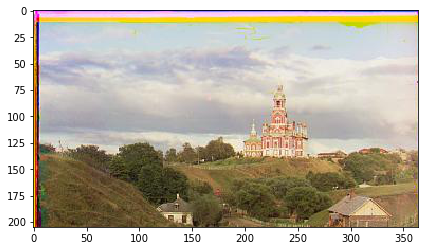

In [207]:
# name of the input file
file_list = os.listdir('./output/pyramid')
file_number = 0
imname = "./output/pyramid/" + file_list[file_number]
# read in the image
im = skio.imread(imname)
# convert to double (might want to do this later on to save memory)
# im = sk.img_as_float(im)
# compute the height of each part (just 1/3 of total)
# height = np.floor(im.shape[0] / 3.0).astype(int)
# # separate color channels
# b = im[:height]
# g = im[height:2 * height]
# r = im[2 * height:3 * height]
# start = time.time()
# print("align g to b")
# ag, shift_ag = pyramid(g, b)
# print("align r to b")
# ar, shift_ar = pyramid(r, b)
# print("The time of execution of above program is :", time.time() - start)
# create a color image
# im_out = np.uint8(np.dstack([ar, ag, b]) * 255)
# crop image
print("Crop image")
im_out = im
# im_out = trim_rgb(im_out, shift_ar, shift_ag)
for i in range(5):
    im_out = trim_border(im_out)

# save the image
jpgname = file_list[file_number].replace(".tif", ".jpg")
fname = './output/crop/' + jpgname
skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()

In [ ]:
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)

# name of the input file
file_list = os.listdir('./data')
for file_name in file_list:
    imname = "./data/" + file_name
    # read in the image
    im = skio.imread(imname)
    # convert to double (might want to do this later on to save memory)
    im = sk.img_as_float(im)
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)
    # separate color channels
    b = im[:height]
    g = im[height:2 * height]
    r = im[2 * height:3 * height]

    print("Processing image" + file_name)
    start = time.time()
    # ag,shift = align(g, b)
    # ar,shift = align(r, b)
    print("align g to b")
    ag = pyramid(g, b)
    print("align r to b")
    ar = pyramid(r, b)
    print("The time of execution of above program is :", time.time() - start)
    # create a color image
    im_out = np.uint8(np.dstack([ar, ag, b]) * 255)
    # save the image
    jpgname = file_name.replace(".tif", ".jpg")
    fname = './output/crop/' + jpgname
    skio.imsave(fname, im_out)

    # display the image
    skio.imshow(im_out)
    skio.show()

Processing imageself_portrait.tif
align g to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
align r to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
The time of execution of above program is : 58.20034861564636


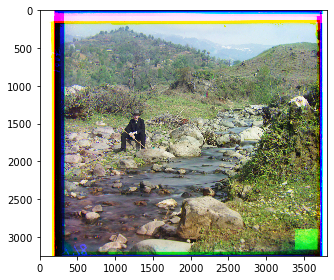

In [3]:
# name of the input file
file_list = os.listdir('./data')
file_number = 5
imname = "./data/" + file_list[file_number]
# read in the image
im = skio.imread(imname)
# convert to double (might want to do this later on to save memory)
im = sk.img_as_float(im)

# print(np.shape(im))

# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height:2 * height]
r = im[2 * height:3 * height]

print("Processing image" + file_list[file_number])
start = time.time()
# ag,shift = align(g, b)
# ar,shift = align(r, b)
print("align g to b")
ag = pyramid(g, b)
print("align r to b")
ar = pyramid(r, b)
print("The time of execution of above program is :", time.time() - start)
# create a color image
im_out = np.uint8(np.dstack([ar, ag, b]) * 255)
# save the image
jpgname = file_list[file_number].replace(".tif", ".jpg")
fname = './output/crop/' + jpgname
skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()

In [65]:
def aaa():
    a = 10
    b = 5
    return a, b


c, d = aaa()
a=np.array([[1,2],[3,4],[5,6]])
# a[:,1]=a[:,0]
bb=np.argwhere(a<4)
print(a.mean(1))

[1.5 3.5 5.5]
